# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each worth 18 points and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False, as_frame = False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### (18pt) Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [15]:
#def Q1():
    ### STUDENT START ###
    
#defining a fucntion named g_blur to apply Gaussian blur to the pic
def g_blur(pic):
        
    dims = (28,28)
    #reshaping to (28,28) matrix
    pic = pic.reshape(dims)
    #start a new array with the same shape as the provided data and make all values as zero in the array 
    p_blurred = np.zeros(pic.shape)
    #Return an iterator yielding pairs of array coordinates and values.
    for index, x in np.ndenumerate(pic):
        #if the value is on the edge then pass through the pic value to the p_blurred
        if index[0] in {0,27} or index[1] in {0,27}:
            np.put(p_blurred[index[0]], index[1], pic[index])    
        else:
            #calculate the weighted blurred pic using gauessan function 
            calc_x = (2*pic[index] + pic[index[0]-1, index[1]-1] + pic[index[0]-1, index[1]]
                        + pic[index[0]-1, index[1]+1] + pic[index[0], index[1]-1]
                        + pic[index[0], index[1]+1]
                        + pic[index[0]+1, index[1]-1] + pic[index[0]+1, index[1]]
                        + pic[index[0]+1, index[1]+1])/10  
            #then put the value to p_blurred array
            np.put(p_blurred[index[0]], index[1], calc_x)
    #reshaping p_blurred
    p_blurred = p_blurred.reshape(784,)
    return p_blurred
    
#defining another function that applies the Gaussian blur from above to all pics
def data_blurr(data):
    #start a new array with the same size as provided data
    data_blurr = np.zeros(data.shape)
    #iterate through each number in the data provided
    for a in range(data.shape[0]):
        #apply the g_blur function and copying it to data_blurr
        data_blurr[a] = g_blur(data[a])
    data_blurr = np.copy(data_blurr)
    return data_blurr
    
# Create blurred mini_train_data
mini_train_data_blurr = np.copy(data_blurr(mini_train_data))

# Creating blurred_dev_data
dev_data_blurr = np.copy(data_blurr(dev_data))


#creating a KNN model without filters
#calculating the accuracy 
knn_model = KNeighborsClassifier()
knn_model.fit(mini_train_data, mini_train_labels)
knn_model_preds = knn_model.predict(dev_data)
accuracy = knn_model.score(X = dev_data, y = dev_labels) 
print ("Accuracy with no filters: " + "\t" + str(accuracy))

#creating a KNN model with filters on mini_training data only
#calculating the accuracy 
knn_model_train_blurr = KNeighborsClassifier()
knn_model_train_blurr.fit(mini_train_data_blurr, mini_train_labels)
accuracy_train_blurr = knn_model_train_blurr.score(X = dev_data, y = dev_labels) 
print ("Accuracy with filters on mini training data only: " + "\t" + str(accuracy_train_blurr))


#creating a KNN model with filters on dev_training data only
#calculating the accuracy 
knn_model_dev_blurr = KNeighborsClassifier()
knn_model_dev_blurr.fit(mini_train_data, mini_train_labels)
accuracy_dev_blurr = knn_model_dev_blurr.score(X = dev_data_blurr, y = dev_labels) 
print ("Accuracy with filters on dev data only: " + "\t" + str(accuracy_dev_blurr))

#creating a KNN model with filters on both mini_training_data_set dev_training data only
#calculating the accuracy 
knn_model_both_blurr = KNeighborsClassifier()
knn_model_both_blurr.fit(mini_train_data_blurr, mini_train_labels)
accuracy_both_blurr = knn_model_train_blurr.score(X = dev_data_blurr, y = dev_labels) 
print ("Accuracy with filters on both mini training data and dev data: " + "\t" + str(accuracy_both_blurr))



### STUDENT END ###

#Q1()

Accuracy with no filters: 	0.882
Accuracy with filters on mini training data only: 	0.902
Accuracy with filters on dev data only: 	0.877
Accuracy with filters on both mini training data and dev data: 	0.907


- It appears that blurring only the mini training data had the highest accuracy, and blurring the dev data only had the lowest accuracy.
- It also appears that blurring filters slightly improves the model accuracy by about 2% as opposed to no blurring in KNN.
- The lowest accuracy came from dev data only, and that makes sense because the model was not trained on blurring on the trainng set. 

### (18pt) Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [14]:
# Solution with binarization by explicit binarize function


#creating a function for threshold
def thresholds(data, thresholds):
    
    #Creating a new array with zeroes
    new_array = np.zeros(data.shape)
    
    #iterate through the given thresholds
    for i, threshold in enumerate(thresholds):
        #setting the new_array 
        new_array[data>threshold] = i + 1
    
    return new_array

def Q2():
    #Binarize with the training data using a threshold
    #setting threshold as 0.1 and choosing alpha as 1
    threshold = 0.1
    alpha = 1
    #fitting model and printing accuracy
    bernoulli_model = BernoulliNB(alpha=alpha, binarize=threshold)
    bernoulli_model.fit(mini_train_data, mini_train_labels)
    print("Binarized Naive Bayes model score: {}".format(bernoulli_model.score(dev_data, dev_labels)))
    
    
    #setting the threshold 
    threshold = [0.1, 0.9]
    
    #creating a new data set after applying the thresholds 
    mini_train_data_multi = thresholds(mini_train_data, threshold)
    dev_data_multi = thresholds(dev_data, threshold)
    
    #fitting model and printing accuracy
    multinomial_model = MultinomialNB(alpha=alpha)
    multinomial_model.fit(mini_train_data_multi, mini_train_labels)    
    print("Multinomial Naive Bayes model score: {}".format(multinomial_model.score(dev_data_multi, dev_labels)))

Q2()

    


Binarized Naive Bayes model score: 0.814
Multinomial Naive Bayes model score: 0.807


ANSWER: The binomial model appears to have better accuracy. The reason could be that for multinomial model the data is being overfitted and not able to generalize as good as binomial model. 

### (18pt) Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [13]:
def Q3(alphas):

### STUDENT START ###
    
    #creating a model with threshold 0
    model1 = BernoulliNB(binarize=0)
    
    #creating the Grid and feeding model1 and alphas
    grid = GridSearchCV(model1, param_grid=alphas)
    
    #fitting the model
    grid.fit(mini_train_data, mini_train_labels)
    

    #iterate through each alphas balues given and print the accuracy
    for a in alphas['alpha']:
        model = BernoulliNB(alpha=a, binarize=0)
        model.fit(mini_train_data, mini_train_labels)
        print("Accuracy of Bernoulli Model with alpha {} : {}".format(a, model.score(dev_data, dev_labels)))
    
    return grid

### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Accuracy of Bernoulli Model with alpha 1e-10 : 0.816
Accuracy of Bernoulli Model with alpha 0.0001 : 0.823
Accuracy of Bernoulli Model with alpha 0.001 : 0.823
Accuracy of Bernoulli Model with alpha 0.01 : 0.824
Accuracy of Bernoulli Model with alpha 0.1 : 0.822
Accuracy of Bernoulli Model with alpha 0.5 : 0.816
Accuracy of Bernoulli Model with alpha 1.0 : 0.809
Accuracy of Bernoulli Model with alpha 2.0 : 0.811
Accuracy of Bernoulli Model with alpha 10.0 : 0.779


GridSearchCV(estimator=BernoulliNB(binarize=0),
             param_grid={'alpha': [1e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0,
                                   2.0, 10.0]})

ANSWER: The best alpha amongst the given alphas is 0.1 with an accuracy of 0.817. It appears that 0.1 is the sweet spot for the alpha for this model. I was not expecting alpha<1 to have a better accuracy than alphas>1. Furhtermore, the accuracy with alpha near zero is lower as expected which essentially explains that there is no smoothing. Alpha of 10.0 yielded a smaller accuracy as well which many indicate over "smoothing". 

### (18pt) Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [12]:
def Q4():

### STUDENT END ###

    #creating the model, printing accuracy and sigma of the model
    model_gaus = GaussianNB()
    model_gaus.fit(mini_train_data, mini_train_labels)
    print ('GaussianNB accuracy: %3.2f' %model_gaus.score(dev_data, dev_labels))
    print('Sigma level: ', model_gaus.sigma_)
    
    #For Gaussian models, the sigma is very small.
    #Increasing the sigma level
    
    model_gaus.sigma_=model_gaus.sigma_+.03
    print ('GaussianNB accuracy with increased sigma: %3.2f' %model_gaus.score(dev_data, dev_labels))


### STUDENT END ###

Q4()

GaussianNB accuracy: 0.59
Sigma level:  [[2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 ...
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]
 [2.01433307e-10 2.01433307e-10 2.01433307e-10 ... 2.01433307e-10
  2.01433307e-10 2.01433307e-10]]
GaussianNB accuracy with increased sigma: 0.81


ANSWER: For Gaussian Models, the sigma level is very small, increasing the sigmal level a little bit seems to have increased the accuracy quite a bit. In other words, the Gaussian model assumes that the data has a gaussian distribution. Our pixel values do not have a normal distribution. This results the model overfitting the data. In our case, adding some "noise" in the form of sigma (variance of each feature) generalized our model, hence increasing the accuracy. 

### (18pt) Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



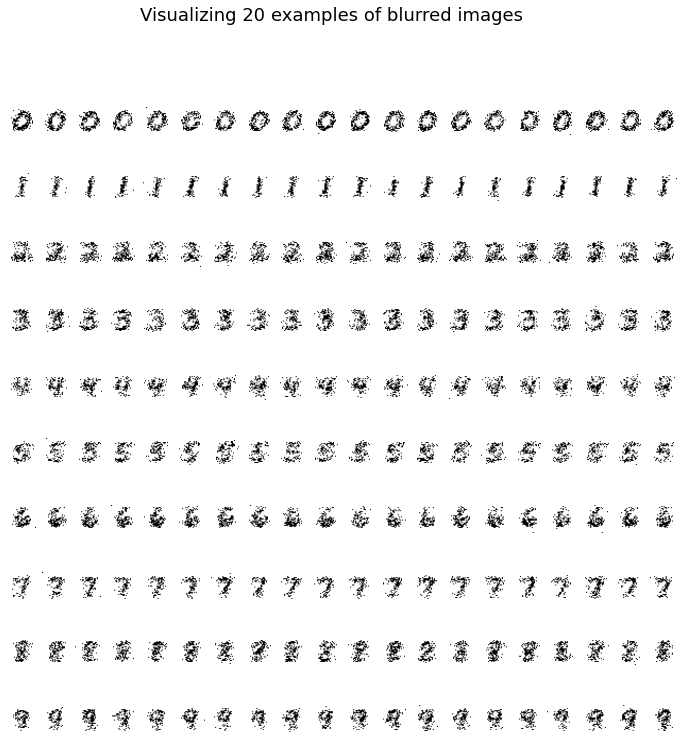

In [11]:
def Q5(num_examples):

### STUDENT START ###
    #binarizing the model with 0.5 due to Bernoulli
    #Fitting the model with mini_data set 
    
    model_a = BernoulliNB(alpha = 0.1, binarize = 0.5)
    model_a = model_a.fit(mini_train_data, mini_train_labels)
    
    #initializing a plot
    fig = plt.figure(figsize= (12,12))
    fig.suptitle('Visualizing 20 examples of blurred images', fontsize = 18)
    
    #iterating to produce 20 examples
    for i in range(num_examples):
        for j in range(10):
            #creating randome arrays
            random_array = np.random.rand(784)
            #converting the log probablity to probability 
            #reshaping
            plot = np.reshape([np.exp(model_a.feature_log_prob_)[j] > random_array], (28,28))
            #adding to the 20x10 grid
            plt.subplot(10, num_examples, j*num_examples + i + 1)
            #rendering matrix and turning axis title off
            plt.imshow(plot, cmap = 'gray_r')
            plt.axis('off')
     
    
### STUDENT END ###

Q5(20)

ANSWER: The generated image for the model is spotty/blurry than than the actual training data. This is because Naive Bayes assume each pixel is independent of it's surrounding pixels.

### (18pt) Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated poste rior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [10]:
def Q6(buckets, correct, total):
    
### STUDENT START ###


    #creating and fitting the model
    model_x = BernoulliNB(alpha = 0.1, binarize=0.5)
    model_x.fit(mini_train_data, mini_train_labels)
    
    #generating predictions porbabilities
    dev_probs = model_x.predict_proba(dev_data)
    
    #creating a new array 
    max_probs = np.array([])
    
    #getting max posterior probability for each value in dev_data
    for i, j in enumerate(dev_probs):
        max_probs = np.append(max_probs, np.max(dev_probs[i]))
    
    #finding predictions/training model
    pred = model_x.predict(dev_data)
    
    #iterating throught max_probs array and finding counts for each bucket
    #enumerate through the array of max posterior probs
    for index, a in np.ndenumerate(max_probs):
        for index_2, b in enumerate(buckets):
            #if max_prob <= to probability value in the buckets, add to bucket
            if a <= b:
                total[index_2] +=1
                #does the predicted value match the label in bucket
                if pred[index] == dev_labels[index]:
                    correct[index_2] += 1
                break
                
                

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)
print(correct)
print(total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('prob(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))


[0, 14, 47, 39, 49, 57, 65, 65, 492]
[0, 45, 90, 77, 65, 62, 75, 72, 514]
prob(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
prob(pred) <= 0.9000000000000    total =  45    accuracy = 0.311
prob(pred) <= 0.9990000000000    total =  90    accuracy = 0.522
prob(pred) <= 0.9999900000000    total =  77    accuracy = 0.506
prob(pred) <= 0.9999999000000    total =  65    accuracy = 0.754
prob(pred) <= 0.9999999990000    total =  62    accuracy = 0.919
prob(pred) <= 0.9999999999900    total =  75    accuracy = 0.867
prob(pred) <= 0.9999999999999    total =  72    accuracy = 0.903
prob(pred) <= 1.0000000000000    total = 514    accuracy = 0.957


ANSWER: It appears that as the posterior probability increases, the accuracy increases as well. Based on the above criteria, this is weakly calibrated classifier. 

### (18pt) Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [ ]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()